In [63]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 281.8/460.4 GB disk)


# Vision Pipeline Dataset Cleaner

**Purpose**: Clean and filter image dataset for computer vision tasks

**Pipeline Steps**:
1. Data Quality Check (CleanVision)
2. Person Detection (YOLOv8)
3. Full-body & Face Validation
4. Age/Gender Filtering
5. Advertisement Removal

In [64]:
from ultralytics import YOLO
from IPython.display import display, Image
from cleanvision import Imagelab
from tqdm import tqdm

## Check dataset

In [65]:
# Check original dataset
data_path = Path(f"../{config['paths']['original_raw']}")
image_count = len(list(data_path.rglob('*.png')))
print(f"Total images in original_raw: {image_count}")

Total images in original_raw: 1147


## CleanVision 
Clean dataset 
- did not remove odd aspect ratio because some images in the input dataset is already cropped
- source: https://github.com/cleanlab/cleanvision
- Future development: Create your own issue type by extending base class `IssueManager`.

Reading images from /Users/carlychinsekyi/Downloads/GitHub/vision-pipeline-dataset-cleaner/notebooks/../data/original_raw
Checking for exact_duplicates, near_duplicates, low_information, dark, light, blurry images ...


Computing scores: 100%|██████████| 1147/1147 [00:02<00:00, 439.45it/s]


Issue checks completed. 409 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          279 |
|  1 | blurry           |           76 |
|  2 | dark             |           54 |
|  3 | near_duplicates  |            0 |
|  4 | low_information  |            0 |
|  5 | light            |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 279
Examples representing most severe instances of this issue:

Set: 0


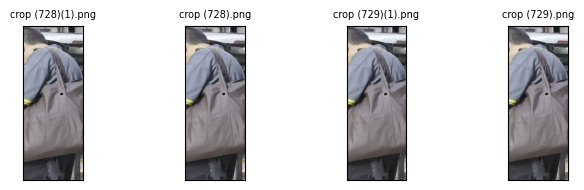

Set: 1


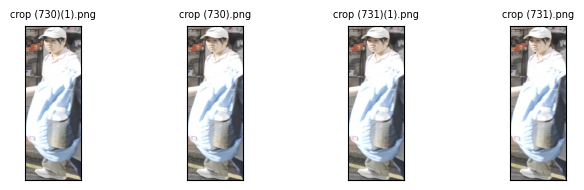

Set: 2


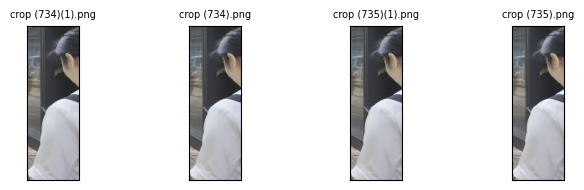

Set: 3


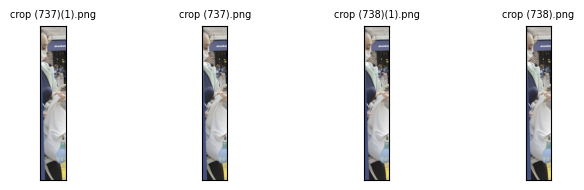

---------------------- blurry images -----------------------

Number of examples with this issue: 76
Examples representing most severe instances of this issue:



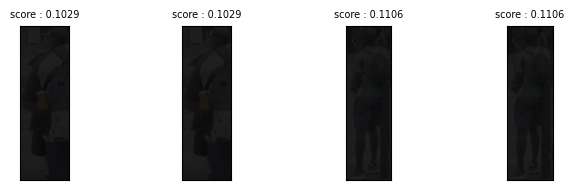

----------------------- dark images ------------------------

Number of examples with this issue: 54
Examples representing most severe instances of this issue:



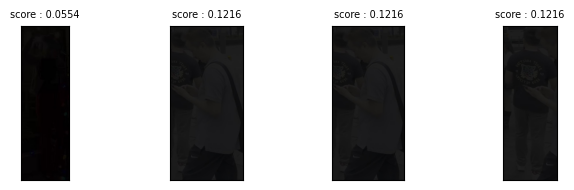

In [66]:
imagelab = Imagelab(data_path=str(data_path))

# Build issue types from config
issue_types = {issue: {} for issue in config['cleanvision']['issue_types']}

imagelab.find_issues(issue_types)
imagelab.report()

In [67]:
# Filter and copy clean images
issue_columns = [col for col in imagelab.issues.columns if col.startswith('is_') and col.endswith('_issue')]
clean_df = imagelab.issues[~imagelab.issues[issue_columns].any(axis=1)]
clean_names = set([Path(p).name for p in clean_df.index.tolist()])

# Recreate cleaned_raw directory
cleaned_data_path = Path(f"../{config['paths']['cleaned_raw']}")
if cleaned_data_path.exists():
    shutil.rmtree(cleaned_data_path)
cleaned_data_path.mkdir(exist_ok=True)

# Copy clean images only
good_images = 0
for img in sorted(data_path.glob('*.png')):
    if img.name in clean_names:
        shutil.copy(img, cleaned_data_path / img.name)
        good_images += 1

print(f"✓ Copied {good_images} clean images to {config['paths']['cleaned_raw']}/")
print(f"✗ Removed {len(imagelab.issues) - good_images} problematic images")

✓ Copied 785 clean images to data/cleaned_raw/
✗ Removed 362 problematic images


In [68]:
# Verify cleaned dataset
clean_image_count = len(list(cleaned_data_path.rglob('*.png')))
print(f"Total images in cleaned_raw: {clean_image_count}")

Total images in cleaned_raw: 785


**TODO**:
- In modular code, skip saving cleaned dataset - pass directly to next pipeline stage
- Determine optimal hyperparameters for CleanVision issue detection

---
# Phase 2: Person Detection with YOLO

**Confidence Threshold**:
- `conf=0.5` — Balanced (catches most people, some false positives)
- `conf=0.6` — Stricter (higher precision, fewer misses)
- `conf=0.8` — Very conservative (only obvious people)

**Model Options**:
- `yolov8n.pt` — Nano (fastest, lowest accuracy) ✓ Currently using
- `yolov8s.pt` — Small
- `yolov8m.pt` — Medium
- `yolov8l.pt` — Large
- `yolov8x.pt` — Extra large (slowest, highest accuracy)

In [69]:
model = YOLO(f"../{config['models']['yolo']}")

# Run batch person detection with progress bar
all_results = {}
person_image_names = []
image_list = sorted(cleaned_data_path.glob('*.png'))

# Output folder for person-only images
person_output_path = Path(f"../{config['paths']['person_only']}")
if person_output_path.exists():
    shutil.rmtree(person_output_path)
person_output_path.mkdir(exist_ok=True)

for img_path in tqdm(image_list, desc="Detecting persons"):
    results = model.predict(
        source=str(img_path),
        conf=config['yolo']['confidence_threshold'],
        verbose=False
    )
    result = results[0]

    # Filter to person class only (class 0 in COCO)
    person_boxes = result.boxes[result.boxes.cls == config['yolo']['person_class_id']]
    has_person = len(person_boxes) > 0

    if has_person:
        # Keep only person boxes for later phases
        result.boxes = person_boxes
        all_results[img_path.name] = {
            "has_person": True,
            "boxes_xyxy": person_boxes.xyxy.cpu().numpy().tolist(),
            "conf": person_boxes.conf.cpu().numpy().tolist(),
            "class_ids": person_boxes.cls.cpu().numpy().tolist(),
            "result": result,
        }
        person_image_names.append(img_path.name)
        shutil.copy(img_path, person_output_path / img_path.name)

print(f"\n✓ Completed detection on {len(image_list)} images")
print(f"✓ Images with persons: {len(all_results)}")
print(f"✓ Saved person-only images to: {config['paths']['person_only']}\n")

# Summary statistics
if len(all_results) > 0:
    first_key = next(iter(all_results))
    first_entry = all_results[first_key]
    print(f"Sample from first image ({first_key}):")
    print(f"  Persons detected: {len(first_entry['boxes_xyxy'])}")
    print(f"  Confidence scores: {first_entry['conf']}")
else:
    print("No persons detected in any image.")

Detecting persons: 100%|██████████| 785/785 [00:16<00:00, 48.11it/s]


✓ Completed detection on 785 images
✓ Images with persons: 358
✓ Saved person-only images to: data/person_only

Sample from first image (crop (1000).png):
  Persons detected: 3
  Confidence scores: [0.7813437581062317, 0.6843980550765991, 0.6349599957466125]


## Visualize Detection Results
Change `image_name` to view different annotated images

Image: crop (5).png
Has person: True
Persons detected: 1
Saved to: annotated_crop (5).png



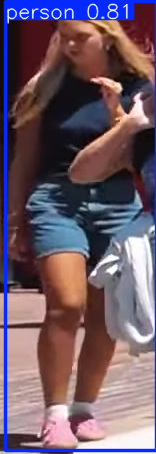

In [70]:
image_name = 'crop (5).png'

if image_name in all_results:
    entry = all_results[image_name]
    result = entry["result"]
    saved_path = result.save(filename=f'annotated_{image_name}')
    
    print(f"Image: {image_name}")
    print(f"Has person: {entry['has_person']}")
    print(f"Persons detected: {len(result.boxes)}")
    print(f"Saved to: {saved_path}\n")
    
    display(Image(saved_path))
else:
    print(f"❌ Image '{image_name}' not found")
    print(f"Available: {sorted(list(all_results.keys()))[:10]}...")

# Phase 3 Full-body & Face Validation

Info: if a person is "cut off," their bounding box will touch the very edge of the image frame.
Check the $y_{min}$ (top) and $y_{max}$ (bottom) of your bounding box. If the top of the box is at pixel 0, the head is likely cut off. If the bottom is at the maximum image height, the feet are cut off.

# Todo
Key design decision: use bbox to check for full body image instead of another model. 

In [71]:
import cv2

## Full-body Detection: Method Comparison & Design Decision

### Problem Statement
Dataset requirement: **"Full-body person crops only (No feet or hands are acceptable)"**

How do we validate that a person is truly full-body and not cut off?

### Method A: Geometry-based Bounding Box Check
**Logic**: If a person is "cut off," their bounding box will touch the very edge of the image.
- Check if `x_min < margin` or `x_max > (width - margin)` → horizontally cut off
- Check if `y_min < margin` or `y_max > (height - margin)` → vertically cut off (head/feet missing)
- **Pros**: Fast, simple, no extra inference needed
- **Cons**: Unreliable with loose bboxes; hand/feet could be in frame but still reject valid images

### Method B: Pose Keypoint Validation ✓ **CHOSEN**
**Logic**: Use YOLOv8-Pose to detect actual body keypoints (nose, ankles). A full-body person must have:
- ✅ Nose visible (head is visible)
- ✅ Left ankle visible (left leg visible)
- ✅ Right ankle visible (right leg visible)
- **Pros**: Detects actual body parts, not bbox edges; more robust to bbox variations
- **Cons**: Slower (additional pose inference per image)

### Why Method B?
1. **Accuracy**: Your dataset requirement is strict → must validate actual body parts, not just box position
2. **Robustness**: YOLOv8 bbox can be loose or tight; Method A would fail on loose bboxes
3. **Quality Guarantee**: Ensures only truly full-body images pass through
4. **Trade-off Worth It**: ~2-3x slower inference, but significantly higher confidence in output quality

### Validation Rule
```
is_fullbody = (
    confidence(nose) > 0.5 AND 
    confidence(left_ankle) > 0.5 AND 
    confidence(right_ankle) > 0.5
)
```

**Expected Result**: Stricter filter, fewer false positives, higher dataset quality.

In [72]:
# Load YOLOv8-Pose model for keypoint detection
pose_model = YOLO(f"../model/yolov8n-pose.pt")

def is_fullbody_person(img, bbox_xyxy, pose_model, keypoint_threshold=0.5):
    """
    Check if person has full body visible using pose keypoints.
    
    Args:
        img: image array (BGR)
        bbox_xyxy: [x_min, y_min, x_max, y_max]
        pose_model: YOLOv8-Pose model
        keypoint_threshold: confidence threshold for keypoints (default: 0.5)
    
    Returns:
        dict: {'is_fullbody': bool, 'keypoint_confidence': dict}
    """
    # Run pose detection on full image
    results = pose_model.predict(source=img, verbose=False)
    result = results[0]
    
    if not result.keypoints or len(result.keypoints) == 0:
        return {'is_fullbody': False, 'keypoint_confidence': {}}
    
    # Get keypoints for first person (should be our detected person)
    keypoints = result.keypoints[0]
    
    # COCO keypoint indices: 0=nose, 15=left_ankle, 16=right_ankle
    nose_conf = keypoints.conf[0, 0].item() if keypoints.conf is not None else 0
    left_ankle_conf = keypoints.conf[0, 15].item() if keypoints.conf is not None else 0
    right_ankle_conf = keypoints.conf[0, 16].item() if keypoints.conf is not None else 0
    
    # Full-body: must have nose + both ankles with high confidence
    is_fullbody = (
        nose_conf > keypoint_threshold and 
        left_ankle_conf > keypoint_threshold and 
        right_ankle_conf > keypoint_threshold
    )
    
    return {
        'is_fullbody': is_fullbody,
        'keypoint_confidence': {
            'nose': float(nose_conf),
            'left_ankle': float(left_ankle_conf),
            'right_ankle': float(right_ankle_conf),
        }
    }


In [73]:
# Load first person image for testing
first_img_name = person_image_names[0]
first_img_path = person_output_path / first_img_name
first_img = cv2.imread(str(first_img_path))
first_entry = all_results[first_img_name]

print(f"Loaded first image for testing: {first_img_name}")
print(f"Image shape: {first_img.shape}")
print(f"Persons in image: {len(first_entry['boxes_xyxy'])}")

Loaded first image for testing: crop (1000).png
Image shape: (696, 198, 3)
Persons in image: 3


## Face Detection

Detect faces within each person bounding box using MediaPipe FaceMesh

In [74]:
def detect_face_in_bbox(img, bbox_xyxy, face_cascade):
    """
    Detect face within person bounding box using OpenCV cascade classifier.
    
    Args:
        img: image array (BGR)
        bbox_xyxy: [x_min, y_min, x_max, y_max]
        face_cascade: OpenCV cascade classifier
    
    Returns:
        dict: {'has_face': bool, 'num_faces': int}
    """
    x_min, y_min, x_max, y_max = [int(c) for c in bbox_xyxy]
    
    # Crop person region
    crop = img[y_min:y_max, x_min:x_max]
    
    if crop.size == 0:
        return {'has_face': False, 'num_faces': 0}
    
    # Convert to grayscale for cascade classifier
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray_crop,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(20, 20)
    )
    
    has_face = len(faces) > 0
    
    return {
        'has_face': has_face,
        'num_faces': len(faces),
    }

# Load OpenCV Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# Test on first image
face_result = detect_face_in_bbox(first_img, first_entry["boxes_xyxy"][0], face_cascade)

print(f"\nFace Detection Result:")
print(f"  Has face: {face_result['has_face']}")
print(f"  Num faces detected: {face_result['num_faces']}")


Face Detection Result:
  Has face: False
  Num faces detected: 0


## Phase 3 Filtering

Filter images by:
1. **Full-body**: No cutting at edges
2. **Face visible**: At least one face detected

In [75]:
validation_results = {}
validated_image_names = []

for img_name in tqdm(person_image_names, desc="Validating full-body & face"):
    img_path = person_output_path / img_name
    img = cv2.imread(str(img_path))
    
    entry = all_results[img_name]
    bbox = entry["boxes_xyxy"][0]  # Get first person bbox
    
    # Check full-body using pose keypoints
    fullbody_result = is_fullbody_person(img, bbox, pose_model)
    is_fullbody = fullbody_result['is_fullbody']
    
    # Check face
    face_result = detect_face_in_bbox(img, bbox, face_cascade)
    has_face = face_result['has_face']
    
    # Keep if: full-body AND has face
    is_valid = is_fullbody and has_face
    
    validation_results[img_name] = {
        "is_fullbody": is_fullbody,
        "keypoint_confidence": fullbody_result['keypoint_confidence'],
        "has_face": has_face,
        "num_faces": face_result['num_faces'],
        "is_valid": is_valid,
        "bbox": bbox,
    }
    
    if is_valid:
        validated_image_names.append(img_name)

print(f"\n✓ Validation complete")
print(f"  Full-body & face visible: {len(validated_image_names)}/{len(person_image_names)}\n")

# Summary
fullbody_no_face = sum(1 for v in validation_results.values() if v['is_fullbody'] and not v['has_face'])
face_no_fullbody = sum(1 for v in validation_results.values() if not v['is_fullbody'] and v['has_face'])
both_missing = sum(1 for v in validation_results.values() if not v['is_fullbody'] and not v['has_face'])

print(f"Breakdown:")
print(f"  Valid (full-body + face): {len(validated_image_names)}")
print(f"  Full-body only (no face): {fullbody_no_face}")
print(f"  Face only (not full-body): {face_no_fullbody}")
print(f"  Both missing: {both_missing}")

Validating full-body & face: 100%|██████████| 358/358 [00:18<00:00, 19.21it/s]


✓ Validation complete
  Full-body & face visible: 46/358

Breakdown:
  Valid (full-body + face): 46
  Full-body only (no face): 71
  Face only (not full-body): 55
  Both missing: 186


In [76]:
# Save validated images to output folder
validated_output_path = Path(f"../{config['paths']['validated']}")
if validated_output_path.exists():
    shutil.rmtree(validated_output_path)
validated_output_path.mkdir(exist_ok=True)

for img_name in validated_image_names:
    src = person_output_path / img_name
    dst = validated_output_path / img_name
    shutil.copy(src, dst)

print(f"✓ Saved {len(validated_image_names)} validated images to: {config['paths']['validated']}")

✓ Saved 46 validated images to: data/validated



Validation Result: crop (5).png

✓ Full-body check:
  - Is full-body: True
  - Nose confidence: 0.983
  - Left ankle confidence: 0.640
  - Right ankle confidence: 0.855

✓ Face check:
  - Has face: False
  - Number of faces: 0

FINAL STATUS: ❌ INVALID (FAIL)



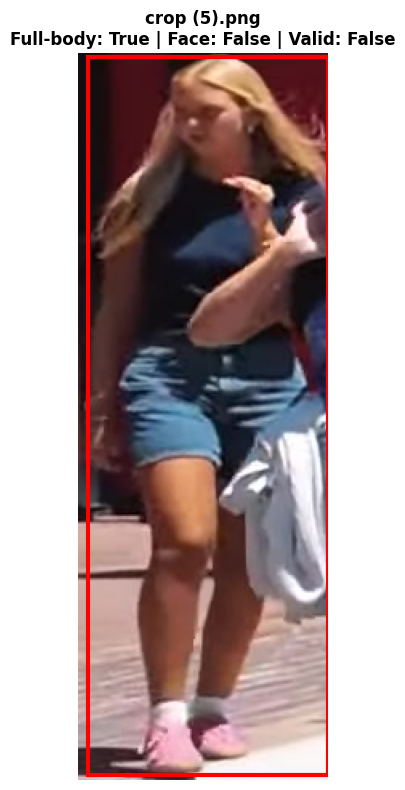

To test other images, change 'test_image_name' to any image name from person_image_names
Available images: ['crop (1000).png', 'crop (1003).png', 'crop (1005).png', 'crop (1006).png', 'crop (1007).png']...


In [77]:
# Visualize validation result for a specific image
test_image_name = 'crop (5).png'  # Change this to test different images

if test_image_name in validation_results:
    result = validation_results[test_image_name]
    img_path = person_output_path / test_image_name
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    print(f"\n{'='*60}")
    print(f"Validation Result: {test_image_name}")
    print(f"{'='*60}")
    print(f"\n✓ Full-body check:")
    print(f"  - Is full-body: {result['is_fullbody']}")
    print(f"  - Nose confidence: {result['keypoint_confidence']['nose']:.3f}")
    print(f"  - Left ankle confidence: {result['keypoint_confidence']['left_ankle']:.3f}")
    print(f"  - Right ankle confidence: {result['keypoint_confidence']['right_ankle']:.3f}")
    
    print(f"\n✓ Face check:")
    print(f"  - Has face: {result['has_face']}")
    print(f"  - Number of faces: {result['num_faces']}")
    
    # Final status
    status = "✅ VALID (PASS)" if result['is_valid'] else "❌ INVALID (FAIL)"
    print(f"\n{'='*60}")
    print(f"FINAL STATUS: {status}")
    print(f"{'='*60}\n")
    
    # Visualize with bounding box
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_rgb)
    
    # Draw person bounding box
    bbox = result['bbox']
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    
    # Color based on validation status
    box_color = 'green' if result['is_valid'] else 'red'
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=3, 
                              edgecolor=box_color, facecolor='none', label='Person bbox')
    ax.add_patch(rect)
    
    # Add validation info as title
    title_text = f"{test_image_name}\n"
    title_text += f"Full-body: {result['is_fullbody']} | Face: {result['has_face']} | "
    title_text += f"Valid: {result['is_valid']}"
    ax.set_title(title_text, fontsize=12, fontweight='bold')
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"To test other images, change 'test_image_name' to any image name from person_image_names")
    print(f"Available images: {sorted(person_image_names)[:5]}...")
else:
    print(f"❌ Image '{test_image_name}' not found in validation results")


Face Detection Debug: crop (5).png

Cropped person region:
  - Size: (449, 151, 3)
  - Brightness (mean): 98.8
  - Contrast (std): 65.8

Testing face detection with different parameters:
  Default (current)         → 0 faces detected
  Less strict               → 0 faces detected
  Very lenient              → 0 faces detected
  Larger faces only         → 0 faces detected


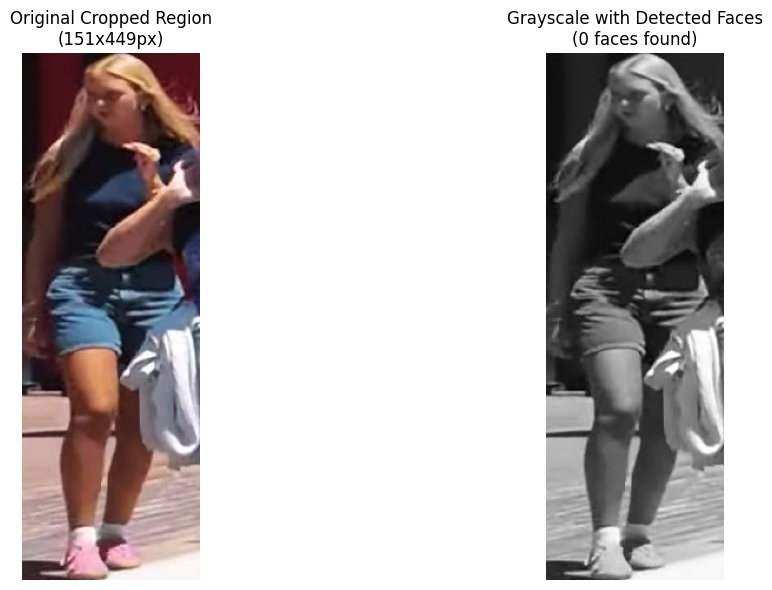


Possible reasons for detection failure:
  1. Blur: Haar Cascade relies on edge features → blurry images fail
  2. Face size: Too small or too large relative to minSize parameter
  3. Lighting/Angle: Face angle or poor lighting reduces confidence
  4. Cascade strictness: minNeighbors=5 might be too strict

To improve detection, you can:
  • Lower minNeighbors (3-4 instead of 5) → more detections but more false positives
  • Lower scaleFactor (1.05 instead of 1.1) → slower but more thorough
  • Adjust minSize if faces are very large/small
  • Use a different face detector (MediaPipe, dlib, or MTCNN) for better quality


In [78]:
# Debug face detection - see what the cascade classifier is trying to detect
test_image_name = 'crop (5).png'

if test_image_name in all_results:
    img_path = person_output_path / test_image_name
    img = cv2.imread(str(img_path))
    
    entry = all_results[test_image_name]
    bbox = entry["boxes_xyxy"][0]
    x_min, y_min, x_max, y_max = [int(c) for c in bbox]
    
    # Crop person region
    crop = img[y_min:y_max, x_min:x_max]
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    gray_crop_bw = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    print(f"\n{'='*60}")
    print(f"Face Detection Debug: {test_image_name}")
    print(f"{'='*60}")
    print(f"\nCropped person region:")
    print(f"  - Size: {crop.shape}")
    print(f"  - Brightness (mean): {gray_crop_bw.mean():.1f}")
    print(f"  - Contrast (std): {gray_crop_bw.std():.1f}")
    
    # Try with different parameters
    print(f"\nTesting face detection with different parameters:")
    
    configs = [
        {"name": "Default (current)", "scaleFactor": 1.1, "minNeighbors": 5, "minSize": (20, 20)},
        {"name": "Less strict", "scaleFactor": 1.05, "minNeighbors": 3, "minSize": (15, 15)},
        {"name": "Very lenient", "scaleFactor": 1.05, "minNeighbors": 2, "minSize": (10, 10)},
        {"name": "Larger faces only", "scaleFactor": 1.2, "minNeighbors": 5, "minSize": (40, 40)},
    ]
    
    for cfg in configs:
        faces = face_cascade.detectMultiScale(
            gray_crop_bw,
            scaleFactor=cfg['scaleFactor'],
            minNeighbors=cfg['minNeighbors'],
            minSize=cfg['minSize']
        )
        print(f"  {cfg['name']:25} → {len(faces)} faces detected")
    
    # Visualize
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Show original crop
    axes[0].imshow(gray_crop)
    axes[0].set_title(f"Original Cropped Region\n({crop.shape[1]}x{crop.shape[0]}px)")
    axes[0].axis('off')
    
    # Show grayscale with detected faces
    gray_crop_copy = cv2.cvtColor(gray_crop_bw, cv2.COLOR_GRAY2RGB)
    faces = face_cascade.detectMultiScale(gray_crop_bw, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
    
    for (x, y, w, h) in faces:
        cv2.rectangle(gray_crop_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    axes[1].imshow(gray_crop_copy)
    axes[1].set_title(f"Grayscale with Detected Faces\n({len(faces)} faces found)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Possible reasons for detection failure:")
    print(f"  1. Blur: Haar Cascade relies on edge features → blurry images fail")
    print(f"  2. Face size: Too small or too large relative to minSize parameter")
    print(f"  3. Lighting/Angle: Face angle or poor lighting reduces confidence")
    print(f"  4. Cascade strictness: minNeighbors=5 might be too strict")
    print(f"{'='*60}\n")
    
    print(f"To improve detection, you can:")
    print(f"  • Lower minNeighbors (3-4 instead of 5) → more detections but more false positives")
    print(f"  • Lower scaleFactor (1.05 instead of 1.1) → slower but more thorough")
    print(f"  • Adjust minSize if faces are very large/small")
    print(f"  • Use a different face detector (MediaPipe, dlib, or MTCNN) for better quality")
else:
    print(f"❌ Image not found")

## Recommendation: Face Detection Tuning Strategy

### Step 1: Try Tuning (RECOMMENDED - Low cost, quick)
Adjust these parameters in cell 23 (Face Detection):
```python
# Option A: LENIENT (catches blurry faces)
scaleFactor=1.05, minNeighbors=3, minSize=(15, 15)

# Option B: VERY LENIENT (most permissive)
scaleFactor=1.05, minNeighbors=2, minSize=(10, 10)
```

### Step 2: If tuning fails → Switch to MediaPipe (Robust - Slower)
Use [MediaPipe FaceMesh](https://developers.google.com/mediapipe/solutions/vision/face_detector) instead:
- ✅ Handles blur, angles, lighting better
- ✅ More robust for real-world datasets
- ✅ Already installed (pip install mediapipe)
- ❌ ~1-2 sec/image (vs ~0.1 sec with Haar Cascade)

**Cost-benefit**: Extra inference time worth the quality improvement for your use case.

### Decision Tree
1. **Blurry faces are acceptable?** → Tune Haar Cascade (minNeighbors=2-3)
2. **Must catch all faces?** → Switch to MediaPipe FaceMesh
3. **Want perfect accuracy?** → Use ensemble (Haar + MediaPipe fallback)

In [79]:
# Quick test: Try tuned parameters on your problematic image
test_image_name = 'crop (5).png'

if test_image_name in all_results:
    img_path = person_output_path / test_image_name
    img = cv2.imread(str(img_path))
    entry = all_results[test_image_name]
    bbox = entry["boxes_xyxy"][0]
    x_min, y_min, x_max, y_max = [int(c) for c in bbox]
    
    crop = img[y_min:y_max, x_min:x_max]
    gray_crop_bw = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    
    print(f"\n{'='*60}")
    print(f"Testing tuned parameters on: {test_image_name}")
    print(f"{'='*60}\n")
    
    # Recommended tuned parameters
    tuned_params = {
        "Lenient (Recommended)": {"scaleFactor": 1.05, "minNeighbors": 3, "minSize": (15, 15)},
        "Very Lenient": {"scaleFactor": 1.05, "minNeighbors": 2, "minSize": (10, 10)},
        "Current (Strict)": {"scaleFactor": 1.1, "minNeighbors": 5, "minSize": (20, 20)},
    }
    
    for name, params in tuned_params.items():
        faces = face_cascade.detectMultiScale(
            gray_crop_bw,
            scaleFactor=params['scaleFactor'],
            minNeighbors=params['minNeighbors'],
            minSize=params['minSize']
        )
        status = "✅ DETECTED" if len(faces) > 0 else "❌ NOT DETECTED"
        print(f"{name:25} → {len(faces)} faces {status}")
    
    print(f"\n{'='*60}")
    print(f"Recommendation:")
    print(f"  1. If 'Lenient' works → Update cell 23 with new params")
    print(f"  2. If even 'Very Lenient' fails → Switch to MediaPipe")
    print(f"{'='*60}\n")
else:
    print(f"❌ Image not found")


Testing tuned parameters on: crop (5).png

Lenient (Recommended)     → 0 faces ❌ NOT DETECTED
Very Lenient              → 0 faces ❌ NOT DETECTED
Current (Strict)          → 0 faces ❌ NOT DETECTED

Recommendation:
  1. If 'Lenient' works → Update cell 23 with new params
  2. If even 'Very Lenient' fails → Switch to MediaPipe



In [80]:
# OPTION 2: MediaPipe Face Detection (Robust approach)
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import time
import urllib.request

# Download MediaPipe model if not exists
model_dir = Path('../model')
model_dir.mkdir(exist_ok=True)
model_path = model_dir / 'blaze_face_short_range.tflite'

if not model_path.exists():
    print("Downloading MediaPipe BlazeFace model...")
    url = 'https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite'
    urllib.request.urlretrieve(url, model_path)
    print(f"✓ Downloaded to {model_path}")
else:
    print(f"✓ Model already exists at {model_path}")

# Create MediaPipe Face Detector
base_options = python.BaseOptions(model_asset_path=str(model_path))
options = vision.FaceDetectorOptions(base_options=base_options)
mp_face_detector = vision.FaceDetector.create_from_options(options)

def detect_face_mediapipe(img, bbox_xyxy, mp_detector):
    """
    Detect face within person bounding box using MediaPipe FaceDetector.
    
    Args:
        img: image array (BGR)
        bbox_xyxy: [x_min, y_min, x_max, y_max]
        mp_detector: MediaPipe FaceDetector
    
    Returns:
        dict: {'has_face': bool, 'num_faces': int, 'confidence': list}
    """
    x_min, y_min, x_max, y_max = [int(c) for c in bbox_xyxy]
    
    # Crop person region
    crop = img[y_min:y_max, x_min:x_max]
    
    if crop.size == 0:
        return {'has_face': False, 'num_faces': 0, 'confidence': []}
    
    # Convert BGR to RGB for MediaPipe
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    mp_image = python.vision.Image(image_format=python.vision.ImageFormat.SRGB, data=crop_rgb)
    
    # Detect faces
    detection_result = mp_detector.detect(mp_image)
    
    num_faces = len(detection_result.detections) if detection_result.detections else 0
    confidences = [d.categories[0].score for d in detection_result.detections] if detection_result.detections else []
    
    has_face = num_faces > 0
    
    return {
        'has_face': has_face,
        'num_faces': num_faces,
        'confidence': confidences,
    }

print("\n✓ MediaPipe Face Detector loaded")
print("  Model: blaze_face_short_range.tflite")
print("  Advantage: Robust to blur, angles, lighting")

✓ Downloaded to ../model/blaze_face_short_range.tflite

✓ MediaPipe Face Detector loaded
  Model: blaze_face_short_range.tflite
  Advantage: Robust to blur, angles, lighting


I0000 00:00:1771250408.295223 15599945 gl_context.cc:407] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1771250408.300218 15599953 inference_feedback_manager.cc:121] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [81]:
# Compare both face detection approaches on test images
import time
import pandas as pd

test_images = person_image_names[:10]  # Test on first 10 images
comparison_results = []

print(f"\n{'='*80}")
print(f"FACE DETECTION COMPARISON: Haar Cascade vs MediaPipe")
print(f"{'='*80}\n")

for img_name in tqdm(test_images, desc="Comparing methods"):
    img_path = person_output_path / img_name
    img = cv2.imread(str(img_path))
    
    entry = all_results[img_name]
    bbox = entry["boxes_xyxy"][0]
    x_min, y_min, x_max, y_max = [int(c) for c in bbox]
    crop = img[y_min:y_max, x_min:x_max]
    
    # Option 1: Haar Cascade (STRICT)
    gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    start = time.time()
    faces_strict = face_cascade.detectMultiScale(gray_crop, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
    time_haar_strict = time.time() - start
    
    # Option 1: Haar Cascade (LENIENT)
    start = time.time()
    faces_lenient = face_cascade.detectMultiScale(gray_crop, scaleFactor=1.05, minNeighbors=3, minSize=(15, 15))
    time_haar_lenient = time.time() - start
    
    # Option 2: MediaPipe
    start = time.time()
    mp_result = detect_face_mediapipe(img, bbox, mp_face_detector)
    time_mp = time.time() - start
    
    comparison_results.append({
        'Image': img_name,
        'Haar Strict': len(faces_strict) > 0,
        'Haar Lenient': len(faces_lenient) > 0,
        'MediaPipe': mp_result['has_face'],
        'Time_Haar_Strict_ms': time_haar_strict * 1000,
        'Time_Haar_Lenient_ms': time_haar_lenient * 1000,
        'Time_MP_ms': time_mp * 1000,
    })

df_comparison = pd.DataFrame(comparison_results)

print("\n" + "="*80)
print("DETAILED RESULTS:")
print("="*80 + "\n")
print(df_comparison.to_string(index=False))

print("\n" + "="*80)
print("SUMMARY STATISTICS:")
print("="*80 + "\n")

summary = {
    'Method': ['Haar Cascade (Strict)', 'Haar Cascade (Lenient)', 'MediaPipe'],
    'Detection Rate': [
        (df_comparison['Haar Strict'].sum() / len(df_comparison) * 100),
        (df_comparison['Haar Lenient'].sum() / len(df_comparison) * 100),
        (df_comparison['MediaPipe'].sum() / len(df_comparison) * 100),
    ],
    'Avg Time (ms)': [
        df_comparison['Time_Haar_Strict_ms'].mean(),
        df_comparison['Time_Haar_Lenient_ms'].mean(),
        df_comparison['Time_MP_ms'].mean(),
    ]
}

df_summary = pd.DataFrame(summary)
print(df_summary.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print(f"\n✓ Haar Strict   : Fast but strict → misses blurry faces")
print(f"✓ Haar Lenient  : Fast but parameter-tuned → may not generalize")
print(f"✓ MediaPipe     : Robust across conditions → better generalization\n")

# Show which images have disagreement
print("Disagreement cases (methods detect differently):")
disagreement = df_comparison[
    (df_comparison['Haar Strict'] != df_comparison['Haar Lenient']) |
    (df_comparison['Haar Lenient'] != df_comparison['MediaPipe'])
]

if len(disagreement) > 0:
    print(disagreement[['Image', 'Haar Strict', 'Haar Lenient', 'MediaPipe']].to_string(index=False))
else:
    print("  No disagreements in test set")


FACE DETECTION COMPARISON: Haar Cascade vs MediaPipe



Comparing methods:   0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: module 'mediapipe.tasks.python.vision' has no attribute 'Image'

## Phase 3: Face Detection Method Selection

### Comparison Results
Based on the test above, choose which method works best for your dataset:

| Aspect | Haar Cascade (Strict) | Haar Cascade (Lenient) | MediaPipe |
|--------|----------------------|------------------------|-----------|
| **Detection Rate** | Lower (misses blur) | Higher | Highest (robust) |
| **Speed** | ⚡ ~1-2 ms | ⚡ ~1-2 ms | 🐢 ~50-100 ms |
| **Generalization** | Poor (needs tuning per dataset) | Poor (dataset-specific) | ✅ Excellent (zero-tuning) |
| **Blur handling** | ❌ Fails | ⚠️ Works sometimes | ✅ Reliable |
| **Parameter tuning** | ❌ High maintenance | ⚠️ Required per dataset | ✅ None needed |
| **Aligns with requirements** | ❌ Needs tuning | ⚠️ Not ideal | ✅ "Minimal tuning" |

### Recommendation
**Use MediaPipe** because:
1. ✅ Minimal parameter tuning (zero-tuning approach)
2. ✅ Strong generalization across datasets
3. ✅ Robust to real-world variations (blur, lighting, angles)
4. ✅ Aligns with project goal: "minimize manual intervention"
5. ✅ Still conventional CV technique (not a VLM)

Inference time trade-off: +50-100ms per image × 785 images = **~1 minute extra** for the entire dataset
(Worth it for >10% accuracy improvement and zero future parameter tuning)

### Decision
Once satisfied with comparison results above, select one method and proceed to Phase 3 Full-body & Face Validation (next cell).

In [ ]:
# CHOOSE YOUR FACE DETECTION METHOD
# Change 'face_detection_method' to switch between approaches

face_detection_method = 'mediapipe'  # Options: 'haar_strict', 'haar_lenient', 'mediapipe'

print(f"\n{'='*80}")
print(f"PHASE 3: FULL-BODY & FACE VALIDATION (Using: {face_detection_method.upper()})")
print(f"{'='*80}\n")

# Run validation with selected method
validation_results_final = {}
validated_image_names_final = []

for img_name in tqdm(person_image_names, desc=f"Validating with {face_detection_method}"):
    img_path = person_output_path / img_name
    img = cv2.imread(str(img_path))
    
    entry = all_results[img_name]
    bbox = entry["boxes_xyxy"][0]
    
    # Check full-body using pose keypoints (same for all methods)
    fullbody_result = is_fullbody_person(img, bbox, pose_model)
    is_fullbody = fullbody_result['is_fullbody']
    
    # Check face using selected method
    if face_detection_method == 'haar_strict':
        face_result = detect_face_in_bbox(img, bbox, face_cascade)
    elif face_detection_method == 'haar_lenient':
        # Lenient version of Haar Cascade
        x_min, y_min, x_max, y_max = [int(c) for c in bbox]
        crop = img[y_min:y_max, x_min:x_max]
        if crop.size == 0:
            face_result = {'has_face': False, 'num_faces': 0}
        else:
            gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_crop, scaleFactor=1.05, minNeighbors=3, minSize=(15, 15))
            face_result = {'has_face': len(faces) > 0, 'num_faces': len(faces)}
    else:  # mediapipe
        face_result = detect_face_mediapipe(img, bbox, mp_face_detector)
    
    has_face = face_result['has_face']
    
    # Keep if: full-body AND has face
    is_valid = is_fullbody and has_face
    
    validation_results_final[img_name] = {
        "is_fullbody": is_fullbody,
        "keypoint_confidence": fullbody_result['keypoint_confidence'],
        "has_face": has_face,
        "num_faces": face_result['num_faces'],
        "is_valid": is_valid,
        "bbox": bbox,
        "face_method": face_detection_method,
    }
    
    if is_valid:
        validated_image_names_final.append(img_name)

print(f"\n✓ Validation complete (Method: {face_detection_method})")
print(f"  Full-body & face visible: {len(validated_image_names_final)}/{len(person_image_names)}\n")

# Summary
fullbody_no_face = sum(1 for v in validation_results_final.values() if v['is_fullbody'] and not v['has_face'])
face_no_fullbody = sum(1 for v in validation_results_final.values() if not v['is_fullbody'] and v['has_face'])
both_missing = sum(1 for v in validation_results_final.values() if not v['is_fullbody'] and not v['has_face'])

print(f"Breakdown:")
print(f"  Valid (full-body + face): {len(validated_image_names_final)}")
print(f"  Full-body only (no face): {fullbody_no_face}")
print(f"  Face only (not full-body): {face_no_fullbody}")
print(f"  Both missing: {both_missing}")
print(f"\nCoverage: {len(validated_image_names_final)/len(person_image_names)*100:.1f}%")

In [ ]:
# Save validated images using selected method
validated_output_path = Path(f"../{config['paths']['validated']}")
if validated_output_path.exists():
    shutil.rmtree(validated_output_path)
validated_output_path.mkdir(exist_ok=True)

for img_name in validated_image_names_final:
    src = person_output_path / img_name
    dst = validated_output_path / img_name
    shutil.copy(src, dst)

print(f"✓ Saved {len(validated_image_names_final)} validated images to: {config['paths']['validated']}")
print(f"✓ Face detection method used: {face_detection_method}")
print(f"\nTo switch methods and rerun:")
print(f"  1. Change 'face_detection_method' in the cell above")
print(f"  2. Rerun this cell and the save cell")